# HW2 - Bayesian Inference in the Poisson Generalized Linear Model

**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Winter, 2021._

---

**Name:** Eric Weiner

**Names of any collaborators:** Ari Beller

*Due: 11:59pm Friday, April 16, 2021 via GradeScope*

---

In this 2nd homework, we will perform Bayesian Inference in the Poisson generalized linear model.

**References:**
- Chapter 16 of BDA3 contains background material on generalized linear models.
- Chapter 7.1 of BDA3 introduces notation for model evaluation based on predictive log likelihoods.
- The data we use comes from [Uzzell & Chichilnisky, 2004](http://jn.physiology.org/content/92/2/780.long). If you're interested, see `README.txt` file in the `/data_RGCs` directory or the [Pillow  tutorial](https://github.com/pillowlab/GLMspiketraintutorial/blob/master/python/tutorial1_PoissonGLM.ipynb) for details.


**Remark:** While some programming languages may incorporate packages that fit Poisson GLMs using one line of code, deriving some of the calculations yourself is an important part of this assignment. Therefore, calls to specialized GLM libraries such as pyglmnet are **prohibited**. Of course, standard libraries such as Numpy are still allowed (and encouraged!). calls to numerical optimizers (such as scipy.optimize.minimize) are fair game. 



## The Poisson GLM
The Poisson distribution is a common model for count data with a single parameter $\lambda \in \mathbb{R}_+$. Its pmf is,
\begin{align}
\Pr(y \mid \lambda) &= \frac{1}{y!} e^{-\lambda} \lambda^y,
\end{align}
for $y \in \mathbb{N}$. Its mean and variance are both equal to $\lambda$.

Suppose we have count observations $y_n \in \mathbb{N}$ along with covariates $x_n \in \mathbb{R}^P$. We construct a Poisson GLM by modeling the expected value as,
\begin{align}
\mathbb{E}[y_n \mid x_n] = f(w^\top x_n),
\end{align}
with $w \in \mathbb{R}^P$ and $f: \mathbb{R} \to \mathbb{R}_+$ is the mean function. The _canonical mean function_ is $f(a) = e^a$; equivalently, the canonical _link_ function is the logarithm.


We assume a Gaussian prior on the weights $w$:
$$
w \sim \mathcal{N}(0, \sigma^2 I),
$$

where $\sigma^2 I$ is the covariance matrix.

## Load the data

The data consists of spike counts from a retinal neuron responding to a flickering light. The spike counts are measured in 8.3ms bins and they range from 0 to 3 spikes/bin. The stimulus is binary, either .48 if the light is on or -.48 if it's off. The goal of this assignment is to model how the neural spike counts relate to recent light exposure over the past 25 time bins (approximately 200ms).

We've provided some code to load the data in Python and plot it. Feel free to convert this to R if that is your preference.

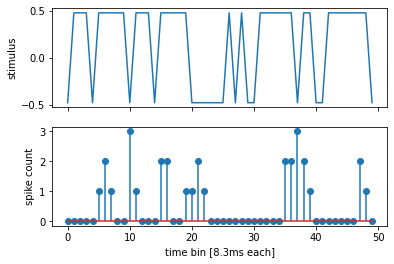

In [5]:
import wget
wget.download('https://raw.githubusercontent.com/slinderman/stats271sp2021/main/assignments/hw2/hw2.csv')
import autograd.numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("hw2.csv")

# Convert the training data to arrays
y_train = np.array(df["y_train"])
stim_train = np.array(df["stim_train"])
N_train = len(y_train)

# Convert the test data to arrays
y_test = np.array(df["y_test"])
stim_test = np.array(df["stim_test"])
N_test = len(y_test)

# Plot the stimulus and spike counts
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(stim_train[:50])
axs[0].set_ylabel("stimulus")
axs[1].stem(y_train[:50], use_line_collection=True)
axs[1].set_ylabel('spike count')
_ = axs[1].set_xlabel('time bin [8.3ms each]')

## Problem 1: Construct the design matrix

Let $y_n \in \mathbb{N}$ denote the spike count in the $n$-th time bin and  $s_n \in \mathbb{R}$ denote the corresponding stimulus at that bin.

Construct the _design matrix_ for the training data $X \in \mathbb{R}^{N_{\mathsf{train}} \times P}$ with rows
\begin{align}
x_n &= (1, s_n, s_{n-1}, \ldots, s_{n-L+1})
\end{align}
where $L=25$ denotes the number of stimulus bins to include in the covariates. (Thus the number of total covariates is $P=L+1$.)

Visualize the first 50 rows of the matrix with, e.g., `imshow`. Don't forget your labels and colorbar.

_Note: Pad the stimulus with zeros so that $s_i = 0$ for $i\leq 0$._

(1000, 26)


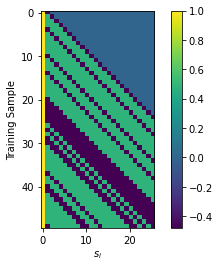

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

i=0
x_train = np.zeros((N_train, 25))
for i in range(N_train):
    for j in range(25):
        if i-j<0:
            x_train[i,j] = 0
        else:
            x_train[i,j] = stim_train[i-j] 

ones = np.ones((1000,1))        
x_train = np.concatenate((ones, x_train), axis =1)
print(np.shape(x_train))
c = plt.imshow(x_train[:50,:])
plt.colorbar(c)
plt.xlabel(r'$s_i$')
plt.ylabel('Training Sample')
plt.show()

## Problem 2a [Math]: Derive the log joint probability
Derive the log joint probability, 
\begin{align}
\mathcal{L}(w) &\triangleq \log p(\{y_n\}_{n=1}^N, w \mid \{x_n\}_{n=1}^N, \sigma^2) \\
&= \ldots
\end{align}

The log joint probability can be decomposed as follows
\begin{align}
\mathcal{L}(w) &\triangleq \log p(\{y_n\}_{n=1}^N, w \mid \{x_n\}_{n=1}^N, \sigma^2) \\
&= log((p(\{y_n\}_{n=1}^N\mid \{x_n\}_{n=1}^N, w) p(w \mid \sigma^2)) \\
&= log(p(\{y_n\}_{n=1}^N\mid \{x_n\}_{n=1}^N, w)+ log(p(w \mid \sigma^2))
\end{align}

We can rewrite the first portion of the above statement as follows:

$$
log p(\{y_n\}_{n=1}^N\mid \{x_n\}_{n=1}^N, w) = log( \prod_{n=1}^N Pois(y_n \mid f(w^Tx_n)))\\
$$

From the problem statement, we have that $f(w^Tx_n) = e^{w^Tx_n}$. Thus, we can now rewrite the expression as:

\begin{equation}
log\displaystyle \prod_{n=1}^N Pois(y_n \mid f(w^Tx_n)) = log\prod_{n=1}^N \frac{e^{-f(w^tx_n)}(f(w^tx_n))^{y_n}}{y_{n}!} = log\prod_{n=1}^N \frac{e^{-e^{w^Tx_n}}e^{{(w^Tx_n)}^{y_n}}}{y_{n}!}
\end{equation}

After distributing the log inside and seeing that the log of products is the sum of logs...

\begin{equation}
\sum_{n=1}^N log \frac{e^{-e^{w^Tx_n}}e^{{(w^Tx_n)}^{y_n}}}{y_{n}!}
\end{equation}

Again, using log rules we can split up the numerator and denominator. The summation applies to all of the terms.

\begin{equation}
\sum_{n=1}^N log \frac{e^{-e^{w^Tx_n}}e^{{(w^Tx_n)}^{y_n}}}{y_{n}!} = \sum_{n=1}^N log (e^{-e^{w^Tx_n}}) +log(e^{{(w^Tx_n)}^{y_n}}) - log(y_{n}!)
\end{equation}

After the simplification of the logarithms and exponents.

\begin{equation}
log p(\{y_n\}_{n=1}^N\mid \{x_n\}_{n=1}^N, w)=\sum_{n=1}^N -e^{w^Tx_n} +(w^Tx_n)y_n - log(y_{n}!)
\end{equation}

We know that the second part of the equation $log(p(w \mid \sigma^2))$ has a normal distribution $w \sim \mathcal{N}(0, \sigma^2 I)$. We can write it as follows:

\begin{equation}
log(p(w \mid \sigma^2)) = log(2\pi)^{-p/2} det(\sigma^2I)^{-\frac{1}{2}} e^{-\frac{1}{2}w^T(\sigma^2I)^{-1}w} =  log (2\pi)^{-p/2} det(\sigma^2I)^{-\frac{1}{2}} e^{-\frac{1}{2}w^T(\sigma^2I)^{-1}w} = log (2\pi)^{-p/2} det(\sigma^2I)^{-\frac{1}{2}} +log e^{-\frac{1}{2}w^T(\sigma^2I)^{-1}w} 
\end{equation}
After some more simplification...

\begin{equation}
log(p(w \mid \sigma^2))=log (2\pi)^{-p/2} det(\sigma^2I)^{-\frac{1}{2}} -\frac{1}{2}w^T(\sigma^2I)^{-1}w 
\end{equation}

Thus, the log joint probability density is:

\begin{equation}
\log p(\{y_n\}_{n=1}^N, w \mid \{x_n\}_{n=1}^N, \sigma^2) = \sum_{n=1}^N \left( -e^{w^Tx_n} +(w^Tx_n)y_n - logy_{n}!\right)+ log (2\pi)^{-p/2} det(\sigma^2I)^{-\frac{1}{2}} -\frac{1}{2}w^T(\sigma^2I)^{-1}w   
\end{equation}




## Problem 2b [Code]: Implement the log probability function
Write a function that computes the log joint probability and evaluate it on the training set with $w=(0, \ldots, 0) \in \mathbb{R}^{P}$ and $\sigma^2 = 1$. **Print your result.**

In [7]:
from math import pi
from numpy import sqrt
import scipy.special

weights = np.zeros((1,26))
sigma = 1
covariance_matrix = (sigma**2)*np.identity(np.shape(weights)[1])

def log_prob(w,x,y,p,cov):
    term1_weight = -p/2*np.log((2*pi)) - 1/2*np.log((np.linalg.det(cov)))
    term2_weight = -(1/2)*np.dot(np.dot(w,np.linalg.inv(cov)),w.T)
    
    xwt = np.dot(x,w.T)
    
    term1_pois = -np.sum(np.exp(xwt)) 
    term2_pois = y@xwt
    term3_pois = -np.sum(np.log(scipy.special.factorial(y)))
   
    
    return  term1_pois + term2_pois +term3_pois +term1_weight +term2_weight

Part2b_answer = log_prob(weights, x_train, y_train,26, covariance_matrix)
print("The log probability is {}".format(Part2b_answer))

The log probability is [[-1125.74647244]]


## Problem 3a [Math]: Derive the gradient
Derive the gradient of the log joint probability
\begin{align}
\nabla_w \mathcal{L}(w) &= \ldots
\end{align}
*Show your work*.

From part 2a, we had the log joint probability as
\begin{equation}
\mathcal{L}(w) = \log p(\{y_n\}_{n=1}^N, w \mid \{x_n\}_{n=1}^N, \sigma^2) = \sum_{n=1}^N \left( -e^{w^Tx_n} +(w^Tx_n)y_n - logy_{n}!\right)+ log (2\pi)^{-p/2} det(\sigma^2I)^{-\frac{1}{2}} -\frac{1}{2}w^T(\sigma^2I)^{-1}w   
\end{equation}

Now we take the gradient:

\begin{equation}
\nabla_w \mathcal{L}(w) = \nabla_w \left(\sum_{n=1}^N \left( -e^{w^Tx_n} +(w^Tx_n)y_n - logy_{n}!\right)+ log (2\pi)^{-p/2} det(\sigma^2I)^{-\frac{1}{2}} -\frac{1}{2}w^T(\sigma^2I)^{-1}w \right)
\end{equation}

First, let's distribute the gradient:
\begin{equation}
\nabla_w \mathcal{L}(w)= \nabla_w \sum_{n=1}^N \left( -e^{w^Tx_n} +(w^Tx_n)y_n - logy_{n}! \right) + \nabla_w \left(log (2\pi)^{-p/2} det(\sigma^2I)^{-\frac{1}{2}} \right) - \nabla_w \left( \frac{1}{2}w^T(\sigma^2I)^{-1}w \right)
\end{equation}

The terms without $w$ disappear:

\begin{equation}
\nabla_w \mathcal{L}(w)= \nabla_w \sum_{n=1}^N \left( -e^{w^Tx_n} +(w^Tx_n)y_n \right) + - \nabla_w \left( \frac{1}{2}w^T(\sigma^2I)^{-1}w \right)
\end{equation}

After taking the derivative, we are left with the following expression for $\nabla_w \mathcal{L}(w)$


\begin{equation}
\nabla_w \mathcal{L}(w)=  \sum_{n=1}^N \left( -x_ne^{w^Tx_n} +x_ny_n \right) - (\sigma^2I)^{-1}w
\end{equation}

## Problem 3b [Code]: Implement the gradient

Write a function to compute the gradient wrt $w$ of the log probability for given values of $w$ and evaluate it on the training set at $w=(0, \ldots, 0) \in \mathbb{R}^{P}$ and $\sigma^2 = 1$. **Print your result.**

**Note:**  While this is not required in this homework, it may be helpful to do numerical checks for gradient and Hessian calculations using finite differences.  See *e.g.* Section 4.2 of https://cilvr.cs.nyu.edu/diglib/lsml/bottou-sgd-tricks-2012.pdf.


 

In [10]:
p=26
def grad_log_prob(x,w,y,cov,p):
    cov_inv_w = -np.dot(np.linalg.inv(cov),w.T)
    xwt = np.dot(x,w.T)
    x_ewx = -np.dot(x.T,np.exp(xwt))
    xy = np.reshape(np.sum(np.multiply(x.T,y), axis = 1), (p,1))
    sumofterms = np.reshape((cov_inv_w + x_ewx +xy), (26,))
    return sumofterms

Part3b_answer = grad_log_prob(x_train, weights, y_train, covariance_matrix, p)
print("The gradient with respect to w of the log joint probability is {}".format(Part3b_answer))


The gradient with respect to w of the log joint probability is [-603.      7.2    18.24   44.64  119.04  145.44   64.32  -51.84  -59.04
  -44.64  -44.16  -47.52  -54.24  -33.12  -27.84  -50.4   -48.    -34.08
  -50.88  -38.88  -22.08  -37.44  -29.76  -11.04    2.4     1.92]


## Problem 4a [Math]: Derive the Hessian
Derive the Hessian of the log joint probability
\begin{align}
\nabla^2_w \mathcal{L}(w) &= \ldots
\end{align}
*Show your work*.

We can rewrite $\nabla^2_w \mathcal{L}(w)$ as 

\begin{equation}
\nabla_w (\nabla_w \mathcal{L}(w))= \nabla_w \left( \sum_{n=1}^N \left( -x_ne^{w^Tx_n} +x_ny_n \right) - (\sigma^2I)^{-1}w \right)
\end{equation}

Distributing the gradient, we get:

\begin{equation}
\nabla^2_w \mathcal{L}(w)= \nabla_w \left( \sum_{n=1}^N -x_ne^{w^Tx_n} +x_ny_n \right) - \nabla_w(\sigma^2I)^{-1}w 
\end{equation}

Applying the gradient with respect to $w$, we simplify to the following expression:

\begin{equation}
\nabla^2_w \mathcal{L}(w)= \sum_{n=1}^N -e^{w^Tx_n}x_nx_n^T - (\sigma^2I)^{-1} = -\left(\sum_{n=1}^N e^{w^Tx_n}x_nx_n^T + (\sigma^2I)^{-1} \right)
\end{equation}

## Problem 4b [Code]: Implement the Hessian

Write a function to compute the Hessian of the log probability for given values of $w$ and $\sigma^2$ and evaluate it on the training set at $w=(0, \ldots, 0) \in \mathbb{R}^{P}$ and $\sigma^2 = 1$. 

Visualize the Hessian with, e.g., `imshow`. Don't forget labels and a colorbar.

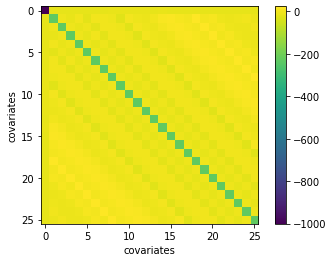

In [11]:
weights = np.zeros((1,26))
sigma = 1
covariance_matrix = (sigma**2)*np.identity(np.shape(weights)[1])
def hessian_of_log(w,x,cov):
    
    ewx_x2 = np.dot(np.multiply(x, np.exp(np.multiply(w, x))).T, x)
    testingterm = np.dot(np.multiply(x.T,np.exp(np.dot(w,x.T))),x)
    return -(testingterm + np.linalg.inv(cov))
   
Part4b_answer = hessian_of_log(weights, x_train, covariance_matrix)

plot_4b = plt.imshow(Part4b_answer)
plt.colorbar(plot_4b)
plt.xlabel('covariates')
plt.ylabel('covariates')
plt.show()



## Problem 5: Compute the Laplace approximation

This problem has two parts. See below.

## Problem 5a: Optimize to find the posterior mode
Optimize the log joint probability to find the posterior mode. You may use built-in optimization libraries (e.g. `scipy.optimize.minimize`).

In [12]:
from scipy.optimize import minimize
def log_prob_foropt(w):
    return -log_prob(w,x_train,y_train,p,covariance_matrix)



def grad_log_prob_foropt(w):
    return -grad_log_prob(x_train,w,y_train,covariance_matrix,p)

def hessian_of_log_foropt(w):
    return -hessian_of_log(w,x_train,covariance_matrix)

optimal_result = scipy.optimize.minimize(log_prob_foropt, x0=np.random.rand(p))

print(optimal_result.x)

[-1.98387939  0.01916075  0.13772378  0.44424193  1.54388209  2.25596694
  0.73980468 -0.53345776 -0.52035018 -0.45324572 -0.41421397 -0.24945071
 -0.47640207 -0.32471352 -0.14218625 -0.26219344 -0.19492639 -0.06752138
 -0.13640138 -0.02965944  0.13819378 -0.06414581  0.03259865 -0.01427331
 -0.01652952 -0.05321334]


## Problem 5b: Approximate the covariance at the mode

Solve for $\Sigma_{\mathsf{MAP}} = -[\nabla^2(\mathcal{L}(w_{\mathsf{MAP}})]^{-1}$. Plot the covariance matrix (e.g. with `imshow`). Don't forget to add a colorbar and labels.

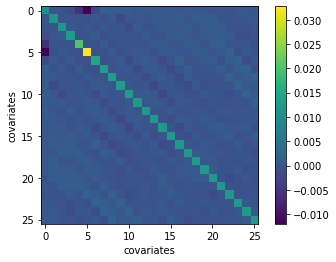

In [13]:
opt_res = optimal_result.x
opt_res = np.reshape(opt_res, (26,1)).T
cov_map = -np.linalg.inv(hessian_of_log(opt_res, x_train, covariance_matrix))


plot_5b = plt.imshow(cov_map)
plt.colorbar(plot_5b)
plt.xlabel('covariates')
plt.ylabel('covariates')
plt.show()


## Problem 6: Plot the posterior of the weights
Plot the posterior mean of the weights for features $s_n, \ldots, s_{n-L+1}$ (i.e. not including the bias term). Also plot 95% credible intervals around the mean by using two standard deviations of the marginal distribution of the weights. Note the diagonal of $\Sigma_{\mathsf{MAP}}$ gives the marginal variance of the posterior. 

Text(0, 0.5, 'Mean Posterior Weight')

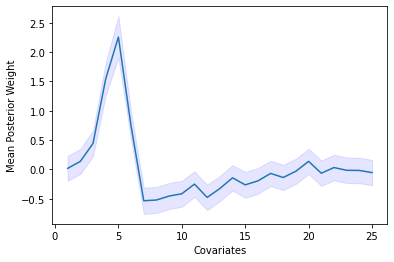

In [14]:
import seaborn as sns
import pandas as pd


optimal_weights = np.reshape(optimal_result.x, (26,1))
opt_trunc = np.delete(optimal_weights, 0, 0)
x_axis_vals = np.reshape(np.array(range(1, 26)), (25,))

var_weights = np.reshape(np.diag(cov_map), (26,1))
var_weights_trunc = np.delete(var_weights, 0, 0)


var_graph = np.reshape((var_weights_trunc), (25,))
weights_graph = np.reshape((opt_trunc), (25,))

ci = 1.96*(np.sqrt(var_graph))

fig, ax3 = plt.subplots()
ax3.plot(x_axis_vals, weights_graph)
ax3.fill_between(x_axis_vals, (weights_graph-ci), (weights_graph+ci), color='b', alpha=.1)
ax3.set_xlabel('Covariates')
ax3.set_ylabel('Mean Posterior Weight')




## Problem 7 [Short Answer]: Interpret your results

Here, the neurons are cells from the retina, which are responsive to light. The stimulus at time bin $n$ is either -0.5 or +0.5 depending on whether a light was off or on, respectively, at that time. What do these weights tell you about the relationship between the stimulus and the spike counts? 

_Answer below this line_

---

It seems to show that there is significant response to the stimulus at the time bin labeled 5 which would be 800 milliseconds after being shown the light. This could lead us to believe that neuron response time peaks roughly 800ms after being shown light. We can see that neurons are responding to stimulus before the n-5 mark and that neuron responsiveness drops off sharply after the n-5 mark. Further, the credible intervals are quite narrow in the drop off range, leading us to believe that indeed there is a steep drop off in response about 5 times bins after exposure. The mean response weight levels off after about 8 times bins after the time measure. The confidence intervals also seem to stabilize.

## Problem 8: Approximate the posterior predictive distribution of the rates

Draw many samples $w^{(s)}$ from the Laplace approximation of the posterior $p(w \mid \{x_n, y_n\})$.  Use those samples to approximate the posterior predictive distribution on the **test** dataset,
\begin{align}
p(y_{n'}=k \mid x_{n'}, \{x_n, y_n\}_{n=1}^N) &= 
\int p(y_{n'} \mid w, x_{n'}) \, p(w \mid \{x_n, y_n\}_{n=1}^N) \, \mathrm{d} w \\
&\approx \frac{1}{S} \sum_{s=1}^S p(y_{n'}=k \mid w^{(s)}, x_{n'})
\end{align}
where
\begin{align}
w^{(s)} &\sim p(w \mid \{x_n, y_n\}_{n=1}^N \\
&\approx \mathcal{N}(w \mid w_{\mathsf{MAP}}, \Sigma_{\mathsf{MAP}})
\end{align}

Visualize the posterior predictive distribution as an $K \times N_{\mathsf{test}}$ array where row corresponds to possible spike counts $k\in \{0,\ldots, K\}$. You can set $K=5$ for this problem. **Only show the first 100 columns (time bins), otherwise it's hard to see changes in the rate.**

Overlay the actual spike counts for the test dataset. 

In [21]:
from scipy.stats import poisson

#creating x_test
i=0
x_test = np.zeros((N_test, 25))
for i in range(N_test):
    for j in range(25):
        if i-j<0:
            x_test[i,j] = 0
        else:
            x_test[i,j] = stim_test[i-j] 

ones = np.ones((1000,1))        
x_test = np.concatenate((ones, x_test), axis =1)


##creating the samples of weight vectors

ws = np.random.multivariate_normal(mean = optimal_result.x, cov = cov_map, size = 1000)

##doing the matrix calculations
temp_a = np.zeros((1000,1))
j=0
J=100
S=1000
s=0
pred_counts = np.zeros((100,1))
for j in range(J):
    for s in range(S):
        temp_a[s,0] = np.exp(x_test[j,:]@ws[s,:])
    pred_counts[j,0] = round(np.sum(temp_a)/S,0)



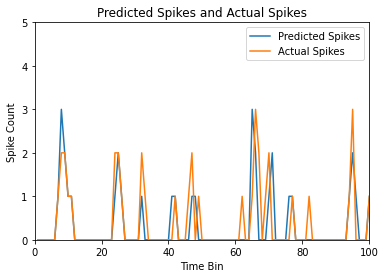

In [34]:
##plotting the predicted vs acutal counts

x_axis_vals8 = np.array(range(1,101))
plt.xlabel("Time Bin")
plt.ylabel("Spike Count")
plt.title("Predicted Spikes and Actual Spikes")
plt.plot(x_axis_vals8, pred_counts, label = "Predicted Spikes")
plt.plot(x_axis_vals8, y_test[0:100,], label = "Actual Spikes")
plt.ylim([0,5])
plt.xlim([0,100])
plt.legend()
plt.show()

## Problem 9: Compute the log predictive density

Simulate from the posterior distribution to compute a Monte Carlo approximation to what the book calls the _log pointwise predictive density_ (Eq. 7.4). 
\begin{align}
\sum_{n'=1}^{N_{\mathsf{test}}} \log p(y_{n'} \mid x_{n'}, \{x_n, y_n\}_{n=1}^N ) 
&= 
\sum_{n'=1}^{N_{\mathsf{test}}} \log \int p(y_{n'} \mid w, x_{n'}) \, p(w \mid \{x_n, y_n\}_{n=1}^N) \, \mathrm{d} w \\
&\approx \sum_{n'=1}^{N_{\mathsf{test}}} \log \frac{1}{S} \sum_{s=1}^S p(y_{n'}=k \mid w^{(s)}, x_{n'})
\end{align}
where
\begin{align}
w^{(s)} &\sim p(w \mid \{x_n, y_n\}_{n=1}^N) \\
&\approx \mathcal{N}(w \mid w_{\mathsf{MAP}}, \Sigma_{\mathsf{MAP}})
\end{align}
Use $S=1000$ Monte Carlo samples and **print your result**.

_Note_: The book recommends a more fully Bayesian approach in which they compute the log pointwise predictive density for one data point at a time, using the remainder to compute the posterior distribution on the weights. For simplicity, we will stick with a single training and test split, as given in the dataset above.

In [61]:

S=1000
s=0
j=0
J = 1000

temp_9 = np.zeros((S,1))
temp_9a = np.zeros((J, 1))


for j in range(J):
    for s in range(S):
        temp_9[s,0] = poisson.pmf(y_test[j-1], mu  = np.exp(x_test[j-1,:]@ws[s-1,:]))
    temp_9a[j-1,0] = np.log(np.sum(temp_9)/S)
lppd = np.sum(temp_9a)

lppd

-533.6648719181687

## Submission Instructions
**Formatting:** check that your code does not exceed 80 characters in line width. If you're working in Colab, you can set Tools → Settings → Editor → Vertical ruler column to 80 to see when you've exceeded the limit.

Download your notebook in .ipynb format and use the following commands to convert it to PDF:

jupyter nbconvert --to pdf hw2_yourname.ipynb

**Dependencies:**

nbconvert: If you're using Anaconda for package management,
conda install -c anaconda nbconvert

**Upload** your .ipynb and .pdf files to Gradescope.